# Experiments on the NSGA-III and NSGA-II on 3-OneMinMax
This notebook contains the code used to benchmark the NSGA-III and NSGA-II on 3-OneMinMax. It employs the [DEAP](https://github.com/DEAP/deap) library, which provides a framework to benchmark evolutionary and genetic algorithms. This library already provides implementations of the selection operators for the NSGA-II and NSGA-III. 

## Adapted implementation of the NSGA-II selection operator
For the NSGA-II, however, if there are multiple elements of same rank and crowding distance eligible for survival, the implementation in the library does not select a random subset but simply the first elements in the list. This leads to an unwanted bias that was also observable in the resulting optimization time. 

Similarly, in the computation of the crowding distances used in the NSGA-II, the library directly works on the list of individuals, which again leads on a bias between elements of the same fitness value in any dimension.  Thus, we adapted the implementation by shuffling the elements before selection to eliminate that bias. 

As a remedy, we adapted the implementation in a minimalistic way by shuffling the list of individuals in both cases before the critical access and thereby eliminating the possible bias in the sorting of the input list of individuals. This is to be found in the methods `my_selNSGA2` and `assignCrowdingDist`, which are exact copies of their counter parts in `deap/tools` except for the highlighted changes to ensure the described shufflings.

## Code for benchmarking

First, we import required libraries and prepare to employ the `DEAP` library with 3-dimensional individuals.

In [24]:
from IPython.core.debugger import set_trace
import random, numpy, sys, math
from math import factorial
from deap import creator, base, tools, algorithms
from itertools import chain

NOBJ = 3   # number objectives

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ)
creator.create("Individual", list, fitness=creator.FitnessMin)

c:\users\swiet\appdata\local\programs\python\python39\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\users\swiet\appdata\local\programs\python\python39\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


The methode `testForCO` allows to run an algorithm (NSGA-II or NSGA-III) to be benchmarked on 3-OneMinMax on individuals with a specified blocksize (equals half the length of the individuals), a certain rate of individuals to which crossover should be applied (`cxpb`), a population size which equals the size of the Pareto front if not specified otherwise, an optional seed for the randomness generator as well as a maximum number of generations to run the genetic algorithm.
This method prepares the essential variables required for the `DEAP` library. The actual execution of the benchmarking is defined by the `nsga` method called in the last line.

In [25]:
def testForCO(BLOCK_SIZE, cxpb, POP_SIZE=None, seed=None, algo="nsga3", verb=False, check=False, NGEN=1000):
    random.seed(seed)
    n = (NOBJ-1) * BLOCK_SIZE


    S = (BLOCK_SIZE+1)*(BLOCK_SIZE+1) # size of Pareto front
    
    MU = POP_SIZE # size of population
    if not MU:
        MU = S 

    if (algo == "nsga3"):
        P = math.ceil(4.65 * n)     # number divisions of reference points, corresponds to > 6*sqrt(3/5)n
        ref_points = tools.uniform_reference_points(NOBJ, P)
    
    def evalFitness(ind):
        vals = [n-sum(ind)]
        for i in range(NOBJ-1):
            vals.append(sum(ind[i*BLOCK_SIZE:(i+1)*BLOCK_SIZE]))
        return tuple(vals)  

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evalFitness)
    toolbox.register("mutate", tools.mutFlipBit, indpb=1/n)
    toolbox.register("mate", tools.cxUniform, indpb=0.5)
     
    if (algo=="nsga3"):
        toolbox.register("select", tools.selNSGA3, ref_points=ref_points)
    elif (algo=="nsga2"):
        toolbox.register("select", my_selNSGA2) 
    else:
         raise Exception('testFor: The choice of algorithm "{0}" is invalid.'.format(algo))
            
    return nsga(toolbox, BLOCK_SIZE, MU, S, 0, cxpb, verb=verb, check=check and(algo=="nsga3"), NGEN=NGEN)


The next block of code contains the adapted implementation of the selection operator of the NSGA-II as described above. The code is exactly the one defined in `DEAP/tools` except for the highlighted changes.

In [26]:
from operator import attrgetter
from itertools import chain

def assignCrowdingDist(individuals):
    """Assign a crowding distance to each individual's fitness. The
    crowding distance can be retrieve via the :attr:`crowding_dist`
    attribute of each individual's fitness.
    """
   # set_trace()
    if len(individuals) == 0:
        return

    distances = [0.0] * len(individuals)
    crowd = [(ind.fitness.values, i) for i, ind in enumerate(individuals)]

    nobj = len(individuals[0].fitness.values)

    for i in range(nobj):
        random.shuffle(crowd)   # This line is added in comparison to the library, 
                # the following lines are alternated to work on sortedCrowd instead of crowd
        sortedCrowd = sorted(crowd, key=lambda element: element[0][i]) 
        distances[sortedCrowd[0][1]] = float("inf")
        distances[sortedCrowd[-1][1]] = float("inf")
        if sortedCrowd[-1][0][i] == sortedCrowd[0][0][i]:
            continue
        norm = nobj * float(sortedCrowd[-1][0][i] - sortedCrowd[0][0][i])
        for prev, cur, next in zip(sortedCrowd[:-2], sortedCrowd[1:-1], sortedCrowd[2:]):
            distances[cur[1]] += (next[0][i] - prev[0][i]) / norm

    for i, dist in enumerate(distances):
        individuals[i].fitness.crowding_dist = dist
        
def my_selNSGA2(individuals, k, nd='standard'):
    """Apply NSGA-II selection operator on the *individuals*. Usually, the
    size of *individuals* will be larger than *k* because any individual
    present in *individuals* will appear in the returned list at most once.
    Having the size of *individuals* equals to *k* will have no effect other
    than sorting the population according to their front rank. The
    list returned contains references to the input *individuals*. For more
    details on the NSGA-II operator see [Deb2002]_.
    :param individuals: A list of individuals to select from.
    :param k: The number of individuals to select.
    :param nd: Specify the non-dominated algorithm to use: 'standard' or 'log'.
    :returns: A list of selected individuals.
    .. [Deb2002] Deb, Pratab, Agarwal, and Meyarivan, "A fast elitist
       non-dominated sorting genetic algorithm for multi-objective
       optimization: NSGA-II", 2002.
    """
    if nd == 'standard':
        pareto_fronts = tools.sortNondominated(individuals, k)
    elif nd == 'log':
        pareto_fronts = tools.sortLogNondominated(individuals, k)
    else:
        raise Exception('selNSGA2: The choice of non-dominated sorting '
                        'method "{0}" is invalid.'.format(nd))

    for front in pareto_fronts:
        assignCrowdingDist(front)

    chosen = list(chain(*pareto_fronts[:-1]))
    k = k - len(chosen)
    if k > 0:
        random.shuffle(pareto_fronts[-1])  # This line is added in comparison to the library
        sorted_front = sorted(pareto_fronts[-1], key=attrgetter("fitness.crowding_dist"), reverse=True)
        chosen.extend(sorted_front[:k])

    return chosen

The next block of code executes the NSGA as defined by its parameters. While doing so, it logs and outputs the number of evaluations and the coverage of the Pareto front for each generation.

In [27]:
def nsga(toolbox, BLOCK_SIZE, MU, S, statsTODO, cxpb=0, verb=True, check=True, NGEN=1000):

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "cover", "pop"
    
    
    current_cover = 0
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("cover", lambda x: current_cover)
    #stats.register("pop", lambda x: x)
   

    pop = toolbox.population(n=MU)
        
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Prepare found matrix to track which indivuals are already found 
    # in order to compute the coverage of the Pareto front and be able
    # to detect whether already found points are lost again
    found = numpy.zeros((BLOCK_SIZE+1,BLOCK_SIZE+1)) -1
    
    for ind in pop:
        indx = int(ind.fitness.values[1])
        indy = int(ind.fitness.values[2])
        if found[indx][indy] < 0:
            found[indx][indy] = 0
            current_cover += 1
        
    # Compile statistics about the population
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    if (verb):
        print(logbook.stream)
    # Begin the generational process
    sys.stdout.write('0           Generation')
    for gen in range(1, NGEN):
        sys.stdout.write('\r' + str(gen) + " " + str(current_cover))
        sys.stdout.flush()
        
        offspring = mutateAndCrossover(pop, toolbox, cxpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population from parents and offspring
        new_pop = toolbox.select(pop + offspring, MU)
        
        
        # Check fail
        current_cover = 0
        for ind in new_pop:
            indx = int(ind.fitness.values[1])
            indy = int(ind.fitness.values[2])
            if found[indx][indy] < gen:
                found[indx][indy] = gen
                current_cover += 1
        if (check):
            for x in range(0, BLOCK_SIZE+1):
                for y in range(0, BLOCK_SIZE+1):    
                    if (found[x][y] > -1 and found[x][y] < gen):
                        print("Pareto Point lost!")
                        set_trace()
        
        pop = new_pop     

        # Compile statistics about the new population
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        if (verb):
            print(logbook.stream)
        
        if (current_cover == S):
            break
    print()
    return gen, pop, logbook

The method `mutateAndCrossover` takes a population and creates an offspring population. 

The population is randomly partioned into pairs of two indivuals and each of these has a chance of `cxpb` to be replaced by their respective uniform crossover output. Afterward, standard mutation is applied to each individual (no matter whether it is the result of crossover or not).

In [28]:
def mutateAndCrossover(population, toolbox, cxpb):
    offspring = [toolbox.clone(ind) for ind in population]
    random.shuffle(offspring)

    if (cxpb > 0):
        for i in range(1, len(offspring), 2):
            if random.random() < cxpb:
                offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1], offspring[i])
    
    for i in range(len(offspring)):
        offspring[i], = toolbox.mutate(offspring[i])
        del offspring[i].fitness.values
    return offspring

The next snippet is used to write data obtained from experiments into a `.csv` file.

In [29]:
import csv

def writeCSV(name, data):
    filename = "{}.csv".format(name)
    with open(filename, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(data)

## Conduction of the benchmarking

### Number of iterations to sample complete Pareto front by NSGA-III

Here, we run the NSGA-3 with various block sizes and crossover rates multiple times in order to determine the number of iterations until the complete Pareto front is sampled. The current settings for the possible block sizes, repetions etc. do not produce our full data used in the paper but can be used to do so by setting the respective values used in the loops. 

In [30]:
BLOCK_SIZE_VALS = [10]
REPS = 2
ALGO = "nsga3"

for i in range(REPS):
    for bs in BLOCK_SIZE_VALS:
        for CXPB in [0.5,0.9]:
            print("Test for block size {}".format(bs))
            gen,p,l = testForCO(bs, algo=ALGO, cxpb=CXPB, NGEN=3000, check=True)
            writeCSV("exp_nsga3", [ALGO, bs, 10*bs*2, (bs+1)*(bs+1), gen, CXPB, 1.0-CXPB])
print("Done")

Test for block size 10
19 109      Generation

KeyboardInterrupt: 

#### Visualization of the above generated data

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
BLOCK_SIZES_TO_SHOW = [5,10,15,20,25]
df = pd.read_csv('exp_nsga3.csv')
df = df[df['blockSize'].isin(BLOCK_SIZES_TO_SHOW)]
dfgsemo = df[df['algo']=='gsemo']
dfgsemoRS = df[df['algo']=='gsemoRandSurvival']
dfgsemoMul = df[df['algo']=='gsemoMulti']
df = df[df['algo']=='nsga3']
df['n'] = df['blockSize']*2

keys = ['algo', 'blockSize', 'refPoints', 'popSize', 'ratioCO', 'ratioMutate']


groupedMut = df[df['ratioCO']==0].groupby(keys).agg(
    meanIt=pd.NamedAgg(column="iterations", aggfunc="mean"),
    stdIt=pd.NamedAgg(column="iterations", aggfunc="std"))
groupedMut.sort_values(by=['blockSize'])

groupedMutCO5 = df[df['ratioCO']==0.5].groupby(keys).agg(
    meanIt=pd.NamedAgg(column="iterations", aggfunc="mean"),
    stdIt=pd.NamedAgg(column="iterations", aggfunc="std"))
groupedMutCO5.sort_values(by=['blockSize'])

groupedMutCO9 = df[df['ratioCO']==0.9].groupby(keys).agg(
    meanIt=pd.NamedAgg(column="iterations", aggfunc="mean"),
    stdIt=pd.NamedAgg(column="iterations", aggfunc="std"))
groupedMutCO9.sort_values(by=['blockSize'])

df = df.sort_values(by=['blockSize'])
display(df[df['ratioCO']==0.0])

,algo,blockSize,refPoints,popSize,iterations,ratioCO,ratioMutate,n
55,nsga3,5,100,36,32,0.0,1.0,10
56,nsga3,5,100,36,21,0.0,1.0,10
57,nsga3,5,100,36,23,0.0,1.0,10
64,nsga3,5,100,36,10,0.0,1.0,10
69,nsga3,5,100,36,35,0.0,1.0,10
75,nsga3,5,100,36,24,0.0,1.0,10
76,nsga3,5,100,36,43,0.0,1.0,10
74,nsga3,5,100,36,37,0.0,1.0,10
65,nsga3,10,200,121,64,0.0,1.0,20
70,nsga3,10,200,121,103,0.0,1.0,20


In [33]:
import matplotlib

def showRunTimes(save=False):
    
    meansMut = numpy.array(groupedMut['meanIt'])
    stds = numpy.array(groupedMut['stdIt'])
    stdsUp = meansMut + stds
    stdsLow = meansMut - stds

    meansMutCO5 = numpy.array(groupedMutCO5['meanIt'])
    meansMutCO9 = numpy.array(groupedMutCO9['meanIt'])

    BLOCK_SIZES_TO_SHOW_2 = [10,20,30,40,50]
    
    plt.plot(BLOCK_SIZES_TO_SHOW_2, meansMut, 'b-', label="crossover rate = 0")
    plt.plot(BLOCK_SIZES_TO_SHOW_2, meansMutCO5, '-', color='orange', label="crossover rate = 0.5")
    plt.plot(BLOCK_SIZES_TO_SHOW_2, meansMutCO9, '-', color='red',label="crossover rate = 0.9")


    for idx, row in df.iterrows():
        pointColor = 'blue'
        if (row['ratioCO'] == 0.5):
            pointColor = 'orange'
        elif (row['ratioCO'] == 0.9):
            pointColor = 'red'
        plt.plot(row['blockSize']*2, row['iterations'], 'x', color=pointColor)


    plt.xlabel('n')
    plt.ylabel('Iterations until covered')
    plt.legend()
    if save: 
        plt.savefig('images/3OMM_N1.pdf')
        print('saved')
    else:
        plt.title('{} on {} with n=2*{} and N={}*|Pareto Front|'.format('NSGA-3', '3OMM',20,1))
        plt.show()

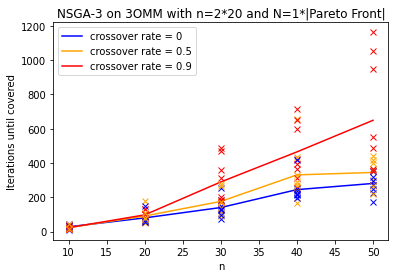

In [34]:
showRunTimes(save=False)

### Coverage of the Pareto front over multiple generations of the NSGA-II and NSGA-III
In the following, we conduct experiments to track the coverage of the Pareto front in the ongoing optimization process in order to compare the development of coverage between the NSGA-III and NSGA-II with different population sizes. Once more, the parameters in the loops would have to be adjusted to different values in order to generate the complete data used in the paper.

In [36]:
BL_SIZE = 20
FRONT_SIZE = (BL_SIZE+1)*(BL_SIZE+1)
SIZE_FACTORS = [2] # By which factor the population size should exceed the Pareto front size 
REPEATS = 1
CX_PROB = 0.0

print("Test NSGA-III")
for i in range(REPEATS):
    gen, pop, log = testForCO(BL_SIZE, CX_PROB)
    covers = []
    for igen in log:
        covers.append(igen["cover"])
    writeCSV("exp_coverage", ["3OMM","nsga3", BL_SIZE, 21*2*BL_SIZE, FRONT_SIZE, CX_PROB, len(covers),covers])

for SIZE_FACTOR in SIZE_FACTORS:
    print("Test NSGA-II, N = {}S".format(SIZE_FACTOR))
    for i in range(REPEATS):
        gen, pop, log = testForCO(BL_SIZE, CX_PROB, POP_SIZE=SIZE_FACTOR*FRONT_SIZE, algo="nsga2", NGEN=500)
        covers = []
        for igen in log:
            covers.append(igen["cover"])
        writeCSV("exp_coverage", ["3OMM","nsga2", BL_SIZE, 0, SIZE_FACTOR*FRONT_SIZE, CX_PROB, len(covers),covers])


Test NSGA-III
1 99

KeyboardInterrupt: 

#### Visualization

In [37]:
dfcover = pd.read_csv('exp_coverage.csv')
dfcover = dfcover[dfcover['cxpb']==0.0]
display(dfcover)

,problem,algo,blockSize,refPoints,popSize,cxpb,iterations,coverages
0,3OMM,nsga2,20,0,441,0.0,500,"[98, 105, 111, 121, 122, 124, 133, 131, 136, 1..."
1,3OMM,nsga2,20,0,882,0.0,500,"[123, 122, 131, 136, 143, 149, 147, 149, 155, ..."
10,3OMM,nsga2,20,0,1764,0.0,500,"[137, 145, 151, 158, 166, 173, 182, 177, 185, ..."
11,3OMM,nsga2,20,0,3528,0.0,500,"[165, 171, 173, 170, 168, 173, 177, 183, 187, ..."
12,3OMM,nsga2,20,0,882,0.0,500,"[128, 130, 132, 137, 141, 143, 149, 153, 162, ..."
15,3OMM,nsga3,20,4410,441,0.0,230,"[98, 107, 117, 132, 141, 155, 167, 186, 197, 2..."
16,3OMM,nsga3,20,4410,441,0.0,161,"[101, 112, 132, 146, 158, 165, 174, 180, 191, ..."
17,3OMM,nsga3,20,4410,441,0.0,220,"[101, 116, 134, 147, 162, 176, 187, 193, 209, ..."
18,3OMM,nsga2,20,0,441,0.0,500,"[99, 105, 109, 113, 122, 129, 126, 128, 133, 1..."
19,3OMM,nsga2,20,0,441,0.0,500,"[103, 106, 112, 113, 123, 132, 135, 136, 144, ..."


In [38]:
import matplotlib

def showCoverageData(blockSize, problem='3OMM', log=False, legend=True, filter= lambda x: True, save=False):
    mydata = dfcover[dfcover['blockSize']== blockSize]
    mydata = mydata[mydata['problem']==problem]
    plottedKeys = []
    colors = {('nsga3',1): 'blue',
             ('nsga2',1): 'red',
             ('nsga2',2): 'orange',
             ('nsga2',4): 'yellow',
             ('nsga2',8): 'green',
            }
    labels = {('nsga3',1): 'NSGA-III, N = Pareto front',
             ('nsga2',1): 'NSGA-II, N = Pareto front',
             ('nsga2',2): 'NSGA-II, N = 2* Pareto front',
             ('nsga2',4): 'NSGA-II, N = 4* Pareto front',
             ('nsga2',8): 'NSGA-II, N = 8* Pareto front',
    #         ('nsga2',1): 'NSGA-II, N = |Pareto front|',
    #         ('nsga2',2): 'NSGA-II, N = 2* |Pareto front|',
    #         ('nsga2',4): 'NSGA-II, N = 4* |Pareto front|',
    #         ('nsga2',8): 'NSGA-II, N = 8* |Pareto front|',
            }
    lines = {0.0: 'solid',
             0.5: 'dashed',
             0.9: 'dotted'}
    
    for idx, row in mydata.iterrows():
        if not filter(row):
            continue
        key = (row['algo'], row['popSize']/((blockSize+1)*(blockSize+1)))
        strCovs = row['coverages'][1:-1].split(', ')
        intCovs = list(map(int, strCovs))
        intCovs = numpy.array(intCovs)
        if log:
            intCovs = numpy.log(((blockSize+1)*(blockSize+1) - intCovs))
        if (key in plottedKeys):
            plt.plot(intCovs, linestyle=lines[row['cxpb']], color=colors[key])
        else:
            plottedKeys.append(key)
            plt.plot(intCovs, linestyle=lines[row['cxpb']], color=colors[key], label=labels[key])

    plt.xlabel('Iteration')
    if log:
        plt.ylabel('log of uncovered Pareto front')
    else:
        plt.ylabel('Number of covered points on the Pareto front')
  #  plt.title('NSGA on {} with n=2*{}'.format(problem,blockSize))
    if legend:
        plt.legend()
    if save: 
       # plt.rcParams.update({'text.usetex': True})
        plt.savefig('images/coverage_{}_BS{}.pdf'.format(problem, blockSize))
    else:
        plt.title('{} with n=2*{}'.format(problem,blockSize))
        plt.show()
    
def showCoverageDataCO(blockSize, algo, popFactor, problem='3OMM', log=False, legend=True, filter= lambda x: True, save=False):
    mydata = dfcover[dfcover['blockSize']== blockSize]
    mydata = mydata[mydata['problem']==problem]
    mydata = mydata[mydata['popSize']==popFactor*(blockSize+1)*(blockSize+1)]
    mydata = mydata[mydata['algo']==algo]
    colors = {0.0: 'blue',
             0.5: 'orange',
             0.9: 'red'}
    plottedKeys = []
    for idx, row in mydata.iterrows():
        if not filter(row):
            continue
        strCovs = row['coverages'][1:-1].split(', ')
        intCovs = list(map(float, strCovs))
        intCovs = numpy.array(intCovs)
        if log:
            intCovs = numpy.log(((blockSize+1)*(blockSize+1) - intCovs))
        if (row['cxpb'] in plottedKeys):
            plt.plot(intCovs, linestyle='solid', color=colors[row['cxpb']])
        else:
            plottedKeys.append(row['cxpb'])
            plt.plot(intCovs, '-', color=colors[row['cxpb']], label='cxpb = {}'.format(row['cxpb']))

  #  S = (blockSize+1)*(blockSize+1)
  #  plt.plot([0,500], [S,S], '--', color='black', label='Pareto front')   
    
    plt.xlabel('Iteration')
    if log:
        plt.ylabel('log of uncovered Pareto front')
    else:
        plt.ylabel('Number of covered points on the Pareto front')
    if legend:
        plt.legend()
    if save: 
        plt.savefig('images/coverage_{}_{}_BS{}_N{}.svg'.format(algo, problem, blockSize, popFactor))
    else:
        plt.title('{} on {} with n=2*{} and N={}*|Pareto Front|'.format(algo, problem,blockSize,popFactor))
        plt.show()

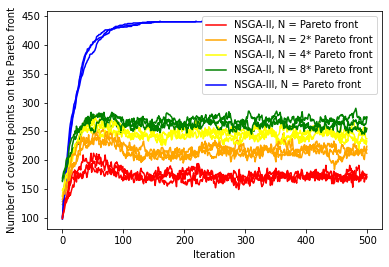

In [21]:
showCoverageData(20, filter=lambda r: r['cxpb']==0, save=True)